# Estudo da previsão do estado de evolução dos pacientes com COVID-19

### Projeto desenvolvido para prever se pacientes de COVID-19 com determinados sintomas tem mais chance de sobreviver ou falecer. Como complemento, o projeto acompanha aplicação web em flask para falicitação de utilização por usuarios finais. Desenvolvido apenas para estudo

In [11]:
""" 
Importando algumas das bibliotecas necessarias e editando as configurações de exposição de dados do pandas
(essa última serve somente para uma pré observação mais extensa dos dados) 
"""

import os
import re
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame

from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [12]:
df1 = pd.read_csv('MICRODADOS (5).csv', sep=';', encoding='latin-1')  # lendo o arquivo csv
df1.tail()

,Data,Classificacao,Evolucao,CriterioConfirmacao,StatusNotificacao,Municipio,Bairro,FaixaEtaria,Sexo,RacaCor,Escolaridade,Febre,DificuldadeRespiratoria,Tosse,Coriza,DorGarganta,Diarreia,Cefaleia,ComorbidadePulmao,ComorbidadeCardio,ComorbidadeRenal,ComorbidadeDiabetes,ComorbidadeTabagismo,ComorbidadeObesidade,FicouInternado,ViagemBrasil,ViagemInternacional
24423,2020-06-10,Confirmados,-,Laboratorial,Em Aberto,CACHOEIRO DE ITAPEMIRIM,CONDURU,0 a 4 anos,M,Ignorado,Não se aplica,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,-,-,-
24424,2020-06-04,Confirmados,-,Laboratorial,Em Aberto,CARIACICA,VALE DOS REIS,05 a 9 anos,M,Ignorado,Não se aplica,Não,Sim,Sim,Sim,Não,Não,Sim,Sim,Não,Não,Não,Não,Não,Não,-,-
24425,2020-05-05,Confirmados,Ignorado,Laboratorial,Em Aberto,CARIACICA,SOTEMA,30 a 39 anos,F,Ignorado,Não se aplica,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,-,-,-
24426,2020-04-16,Confirmados,Cura,Laboratorial,Encerrado,CARIACICA,TABAJARA,30 a 39 anos,M,Ignorado,Não se aplica,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,-,-,-
24427,2020-05-08,Confirmados,Cura,Laboratorial,Encerrado,CARIACICA,PORTO DE SANTANA,40 a 49 anos,M,Ignorado,Não se aplica,Não,Sim,Não,Não,Não,Não,Sim,Não,Sim,Não,Não,Não,Sim,Sim,-,-


In [13]:
""" 
Aqui selecionaremos as features com menos ausencia de dados e que mais tem chance de se relacionar com a o estado de evolução dos pacientes 
"""


dfmodel = df1.drop(df1[df1.Evolucao == 'Ignorado'].index) 
dfmodel = dfmodel.drop(dfmodel[dfmodel.Municipio == 'SAO MATEUS'].index) 
dfmodel = dfmodel.drop(dfmodel[dfmodel.Evolucao == '-'].index) 
dfmodel = dfmodel.drop(dfmodel[dfmodel.Evolucao == 'Óbito por outras causas'].index) 
dfmodel = dfmodel.drop(['Classificacao', 'Municipio', 'Escolaridade', 'Data', 'StatusNotificacao', 'Bairro', 'ViagemBrasil', 'ViagemInternacional'], axis = 1)
dfmodel = dfmodel.drop(dfmodel[dfmodel.CriterioConfirmacao == 'Clinico'].index) 
dfmodel = dfmodel.drop(dfmodel[dfmodel.Sexo == 'I'].index)

dfmodel

,Evolucao,CriterioConfirmacao,FaixaEtaria,Sexo,RacaCor,Febre,DificuldadeRespiratoria,Tosse,Coriza,DorGarganta,Diarreia,Cefaleia,ComorbidadePulmao,ComorbidadeCardio,ComorbidadeRenal,ComorbidadeDiabetes,ComorbidadeTabagismo,ComorbidadeObesidade,FicouInternado
2,Cura,Laboratorial,80 a 89 anos,F,Branca,Não,Não,Sim,Não,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não
6,Cura,Laboratorial,50 a 59 anos,M,Branca,Sim,Não,Não,Sim,Sim,Não,Sim,Não,Não,Não,Não,Não,Não,Não
8,Cura,Clinico Epdemiologico,0 a 4 anos,F,Branca,Sim,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não
10,Cura,Clinico Epdemiologico,0 a 4 anos,M,Branca,Sim,Não,Sim,Não,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não
11,Cura,Laboratorial,70 a 79 anos,F,Branca,Sim,Sim,Sim,Sim,Não,Não,Sim,Não,Sim,Não,Não,Não,Não,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24408,Cura,Laboratorial,10 a 19 anos,F,Ignorado,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,-
24410,Cura,Laboratorial,70 a 79 anos,F,Ignorado,Não,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não
24414,Cura,Laboratorial,40 a 49 anos,M,Ignorado,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,-
24426,Cura,Laboratorial,30 a 39 anos,M,Ignorado,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,-


In [14]:
""" 
Aqui excluiremos os Outliers mais extremos, onde o paciente não apresenta sintoma algum e ainda assim vem a falecer pela doença
"""

dfsamplest = dfmodel.drop(dfmodel[(dfmodel.FicouInternado == 'Não') & (dfmodel.Evolucao == 'Óbito pelo COVID-19') & (dfmodel.Febre == 'Não') & (dfmodel.DificuldadeRespiratoria == 'Não') & (dfmodel.Tosse == 'Não') & (dfmodel.Coriza == 'Não') & (dfmodel.DorGarganta == 'Não') & (dfmodel.Diarreia == 'Não') & (dfmodel.Cefaleia == 'Não') & (dfmodel.ComorbidadePulmao == 'Não') & (dfmodel.ComorbidadeCardio == 'Não') & (dfmodel.ComorbidadeRenal == 'Não') & (dfmodel.ComorbidadeDiabetes == 'Não') & (dfmodel.ComorbidadeTabagismo == 'Não') & (dfmodel.ComorbidadeObesidade == 'Não')].index) 

In [15]:
""" 
É importante observar a quantidade de dados para cada classificação que se deseja alcançar. Aqui possuímos poucos dados para os mortos, o que fará nossos dados terem menos precisão com essa classificação, todavia, como o princípio aqui
é o estudo e aparentemente não conseguiremos dados melhores, usaremos estes mesmo.
"""

dfsamplest.Evolucao.value_counts()

Cura                   13056
Óbito pelo COVID-19      946
Name: Evolucao, dtype: int64

In [16]:
""" 
Substituiremos as strings que temos por valores numéricos, para que o modelo classificatório possa interpreta-los
"""

dfsamplest = dfsamplest.replace(to_replace = ['-'],value = ['99']) 

In [17]:
from sklearn.preprocessing import LabelEncoder

Evolucao_values = {'Cura' : 0, 'Óbito pelo COVID-19' : 1} 
CriterioConfirmacao_values = {'Laboratorial' : 0, 'Clinico Epdemiologico' : 1} 
FaixaEtaria_values = {'0 a 4 anos' : 0, '05 a 9 anos' : 1, '10 a 19 anos' : 2, '20 a 29 anos' : 3, '30 a 39 anos' : 4, '40 a 49 anos' : 5, '50 a 59 anos' : 6, '60 a 69 anos' : 7, '70 a 79 anos' : 8, '80 a 89 anos' : 9, '90 anos ou mais' : 10} 
Sexo_values = {'F' : 0, 'M' : 1} 
RacaCor_values = {'Branca' : 0, 'Preta' : 1, 'Amarela' : 2, 'Parda' : 3, 'Ignorado' : 4, 'Indigena' : 5} 
Febre_values = {'Sim' : 0, 'Não' : 1} 
DificuldadeRespiratoria_values = {'Sim' : 0, 'Não' : 1}
Tosse_values = {'Sim' : 0, 'Não' : 1}
Coriza_values = {'Sim' : 0, 'Não' : 1}
DorGarganta_values = {'Sim' : 0, 'Não' : 1}
Diarreia_values = {'Sim' : 0, 'Não' : 1}
Cefaleia_values = {'Sim' : 0, 'Não' : 1}
ComorbidadePulmao_values = {'Sim' : 0, 'Não' : 1}
ComorbidadeCardio_values = {'Sim' : 0, 'Não' : 1}
ComorbidadeRenal_values = {'Sim' : 0, 'Não' : 1}
ComorbidadeDiabetes_values = {'Sim' : 0, 'Não' : 1}
ComorbidadeTabagismo_values = {'Sim' : 0, 'Não' : 1}
ComorbidadeObesidade_values = {'Sim' : 0, 'Não' : 1}
FicouInternado_values = {'Sim' : 0, 'Não' : 1}

dfsamplest.replace({'Evolucao': Evolucao_values,
                 'CriterioConfirmacao': CriterioConfirmacao_values,
                 'FaixaEtaria': FaixaEtaria_values, 
                 'RacaCor': RacaCor_values, 
                 'Sexo': Sexo_values, 
                 'Febre': Febre_values, 
                 'DificuldadeRespiratoria': DificuldadeRespiratoria_values, 
                 'Tosse': Tosse_values, 
                 'Coriza': Coriza_values, 
                 'DorGarganta': DorGarganta_values, 
                 'Diarreia': Diarreia_values,
                 'Cefaleia': Cefaleia_values, 
                 'ComorbidadePulmao': ComorbidadePulmao_values, 
                 'ComorbidadeCardio': ComorbidadeCardio_values, 
                 'ComorbidadeRenal': ComorbidadeRenal_values,
                 'ComorbidadeDiabetes': ComorbidadeDiabetes_values, 
                 'ComorbidadeTabagismo': ComorbidadeTabagismo_values,
                 'ComorbidadeObesidade': ComorbidadeObesidade_values,
                 'FicouInternado': FicouInternado_values
                }, inplace=True)

In [18]:
dfsamplest

,Evolucao,CriterioConfirmacao,FaixaEtaria,Sexo,RacaCor,Febre,DificuldadeRespiratoria,Tosse,Coriza,DorGarganta,Diarreia,Cefaleia,ComorbidadePulmao,ComorbidadeCardio,ComorbidadeRenal,ComorbidadeDiabetes,ComorbidadeTabagismo,ComorbidadeObesidade,FicouInternado
2,0,0,9,0,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1
6,0,0,6,1,0,0,1,1,0,0,1,0,1,1,1,1,1,1,1
8,0,1,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1
10,0,1,0,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1
11,0,0,8,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24408,0,0,2,0,4,1,1,1,1,1,1,1,1,1,1,1,1,1,99
24410,0,0,8,0,4,1,0,0,1,1,1,1,1,1,1,1,1,1,1
24414,0,0,5,1,4,1,1,0,1,1,1,1,1,1,1,1,1,1,99
24426,0,0,4,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,99


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
""" 
Fatiando os dados em partes de treino e partes de teste e posteriormente aplicaremos uma série de modelos classificatórios, analisaremos suas precisões e escolheremos qual aplicar na aplicação web
"""

X = dfsamplest.drop(['Evolucao'], axis=1)
y = dfsamplest['Evolucao']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

print ('X_train: numero de linhas e colunas: {}'.format(X_train.shape))
print ('X_test: numero de linhas e colunas: {}'.format(X_test.shape))
print ('y_train: numero de linhas e colunas: {}'.format(y_train.shape))
print ('y_test: numero de linhas e colunas: {}'.format(y_test.shape))

X_train: numero de linhas e colunas: (11201, 18)
X_test: numero de linhas e colunas: (2801, 18)
y_train: numero de linhas e colunas: (11201,)
y_test: numero de linhas e colunas: (2801,)


### **Decision tree**

In [18]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

91.82 %


In [19]:
resultado_final = decision_tree.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.0817565155301678

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.6909826635211245

In [21]:
print(pd.crosstab(y_test, decision_tree.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito     0    1   All
Real                    
0        2493  124  2617
1         105   79   184
All      2598  203  2801


In [22]:
scores = cross_val_score(decision_tree, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.9178889737713266

In [23]:
probs = pd.DataFrame(decision_tree.predict_proba(X_test))
probs = probs.rename(columns={0: 'probs', 1: 'probs2'})
probs.probs.value_counts()

1.000000    2517
0.000000     201
0.500000      32
0.666667      15
0.985075      12
0.916667       7
0.800000       4
0.857143       3
0.750000       3
0.833333       2
0.900000       2
0.333333       2
0.600000       1
Name: probs, dtype: int64

In [24]:
probs.probs2.value_counts()

0.000000    2517
1.000000     201
0.500000      32
0.333333      15
0.014925      12
0.083333       7
0.200000       4
0.142857       3
0.250000       3
0.100000       2
0.666667       2
0.166667       2
0.400000       1
Name: probs2, dtype: int64

### **Support Vector Machine**

In [25]:
from sklearn import svm, tree

svm = svm.SVC(probability=True)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

acc_decision_tree = round(svm.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

93.43 %


In [26]:
resultado_final = svm.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.06569082470546234

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.5

In [28]:
print(pd.crosstab(y_test, svm.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito     0   All
Real               
0        2617  2617
1         184   184
All      2801  2801


In [29]:
scores = cross_val_score(svm, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.9335949834479248

In [30]:
svm.predict_proba(X_test)


array([[0.62416009, 0.37583991],
       [0.90663604, 0.09336396],
       [0.8671503 , 0.1328497 ],
       ...,
       [0.98412379, 0.01587621],
       [0.9872264 , 0.0127736 ],
       [0.98918247, 0.01081753]])

### **XGBOOST**

In [31]:
print(X_train.dtypes)

CriterioConfirmacao        object
FaixaEtaria                 int64
Sexo                        int64
RacaCor                     int64
Febre                      object
DificuldadeRespiratoria    object
Tosse                      object
Coriza                     object
DorGarganta                object
Diarreia                   object
Cefaleia                   object
ComorbidadePulmao          object
ComorbidadeCardio          object
ComorbidadeRenal           object
ComorbidadeDiabetes        object
ComorbidadeTabagismo       object
ComorbidadeObesidade       object
FicouInternado             object
dtype: object


In [32]:
X_train['CriterioConfirmacao'] = pd.to_numeric(X_train['CriterioConfirmacao'])
X_train['FaixaEtaria'] = pd.to_numeric(X_train['FaixaEtaria'])
X_train['Sexo'] = pd.to_numeric(X_train['Sexo'])
X_train['RacaCor'] = pd.to_numeric(X_train['RacaCor'])
X_train['Febre'] = pd.to_numeric(X_train['FaixaEtaria'])
X_train['DificuldadeRespiratoria'] = pd.to_numeric(X_train['DificuldadeRespiratoria'])
X_train['Tosse'] = pd.to_numeric(X_train['Tosse'])
X_train['Coriza'] = pd.to_numeric(X_train['Coriza'])
X_train['DorGarganta'] = pd.to_numeric(X_train['DorGarganta'])
X_train['Diarreia'] = pd.to_numeric(X_train['Diarreia'])
X_train['Cefaleia'] = pd.to_numeric(X_train['Cefaleia'])
X_train['ComorbidadePulmao'] = pd.to_numeric(X_train['ComorbidadePulmao'])
X_train['ComorbidadeCardio'] = pd.to_numeric(X_train['ComorbidadeCardio'])
X_train['ComorbidadeRenal'] = pd.to_numeric(X_train['ComorbidadeRenal'])
X_train['ComorbidadeDiabetes'] = pd.to_numeric(X_train['ComorbidadeDiabetes'])
X_train['ComorbidadeTabagismo'] = pd.to_numeric(X_train['ComorbidadeTabagismo'])
X_train['ComorbidadeObesidade'] = pd.to_numeric(X_train['ComorbidadeObesidade'])
X_train['FicouInternado'] = pd.to_numeric(X_train['FicouInternado'])

X_test['CriterioConfirmacao'] = pd.to_numeric(X_test['CriterioConfirmacao'])
X_test['FaixaEtaria'] = pd.to_numeric(X_test['FaixaEtaria'])
X_test['Sexo'] = pd.to_numeric(X_test['Sexo'])
X_test['RacaCor'] = pd.to_numeric(X_test['RacaCor'])
X_test['Febre'] = pd.to_numeric(X_test['FaixaEtaria'])
X_test['DificuldadeRespiratoria'] = pd.to_numeric(X_test['DificuldadeRespiratoria'])
X_test['Tosse'] = pd.to_numeric(X_test['Tosse'])
X_test['Coriza'] = pd.to_numeric(X_test['Coriza'])
X_test['DorGarganta'] = pd.to_numeric(X_test['DorGarganta'])
X_test['Diarreia'] = pd.to_numeric(X_test['Diarreia'])
X_test['Cefaleia'] = pd.to_numeric(X_test['Cefaleia'])
X_test['ComorbidadePulmao'] = pd.to_numeric(X_test['ComorbidadePulmao'])
X_test['ComorbidadeCardio'] = pd.to_numeric(X_test['ComorbidadeCardio'])
X_test['ComorbidadeRenal'] = pd.to_numeric(X_test['ComorbidadeRenal'])
X_test['ComorbidadeDiabetes'] = pd.to_numeric(X_test['ComorbidadeDiabetes'])
X_test['ComorbidadeTabagismo'] = pd.to_numeric(X_test['ComorbidadeTabagismo'])
X_test['ComorbidadeObesidade'] = pd.to_numeric(X_test['ComorbidadeObesidade'])
X_test['FicouInternado'] = pd.to_numeric(X_test['FicouInternado'])

In [33]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)

Y_pred = xgb.predict(X_test)

acc_decision_tree = round(xgb.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

94.43 %


In [34]:
resultado_final = xgb.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.05569439485897894

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.7125089299064644

In [36]:
print(pd.crosstab(y_test, xgb.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito     0    1   All
Real                    
0        2563   54  2617
1         102   82   184
All      2665  136  2801


In [37]:
scores = cross_val_score(xgb, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.9364565826330532

In [38]:
xgb.predict_proba(X_test)

array([[1.8195105e-01, 8.1804895e-01],
       [9.9899769e-01, 1.0022894e-03],
       [6.7782235e-01, 3.2217768e-01],
       ...,
       [9.9682599e-01, 3.1740146e-03],
       [9.9994725e-01, 5.2732419e-05],
       [9.9924135e-01, 7.5862854e-04]], dtype=float32)

### **Random Forest Classifier**

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]}
rf_best = RandomForestClassifier()
grid = GridSearchCV(rf_best, parametros)
grid.fit(X_train, y_train)

grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 750}

In [22]:
rf_best = grid.best_estimator_
rf_best.score(X_test, y_test)
acc_random_forest = round(rf_best.score(X_test, y_test) * 100, 2)
print(round(acc_random_forest,2,), "%")

94.75 %


In [23]:
resultado_final = rf_best.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.052481256694037845

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.6839124619959797

In [25]:
print(pd.crosstab(y_test, rf_best.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito     0    1   All
Real                    
0        2584   33  2617
1         114   70   184
All      2698  103  2801


In [26]:
scores = cross_val_score(rf_best, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.9482346574993634

In [27]:
rf_best.predict_proba(X_test)

array([[3.39070867e-01, 6.60929133e-01],
       [1.00000000e+00, 0.00000000e+00],
       [5.27152349e-01, 4.72847651e-01],
       ...,
       [9.99528042e-01, 4.71957672e-04],
       [1.00000000e+00, 0.00000000e+00],
       [9.93898215e-01, 6.10178525e-03]])

### **Naive Bayes Classifier**

In [46]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

Y_pred = gnb.predict(X_test)

acc_decision_tree = round(gnb.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

33.81 %


In [47]:
resultado_final = gnb.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.6619064619778651

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.6179879467029954

In [49]:
print(pd.crosstab(y_test, gnb.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito    0     1   All
Real                    
0        774  1843  2617
1         11   173   184
All      785  2016  2801


In [50]:
scores = cross_val_score(gnb, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.2209816653934301

In [51]:
gnb.predict_proba(X_test)

array([[5.28170088e-004, 9.99471830e-001],
       [1.00000000e+000, 1.40535464e-167],
       [6.26837860e-006, 9.99993732e-001],
       ...,
       [3.48684282e-002, 9.65131572e-001],
       [6.86658009e-001, 3.13341991e-001],
       [6.48287897e-001, 3.51712103e-001]])

### **Stochastic Gradient Descent**

In [52]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="modified_huber", penalty="l2", max_iter=5)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)

acc_decision_tree = round(sgd.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

93.65 %


In [53]:
resultado_final = sgd.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.0635487325955016

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.5819890016779916

In [55]:
print(pd.crosstab(y_test, sgd.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito     0   1   All
Real                   
0        2591  26  2617
1         152  32   184
All      2743  58  2801


In [56]:
scores = cross_val_score(sgd, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.9200210084033614

In [57]:
sgd.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### **K-Nearest Neighbors**

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_decision_tree = round(knn.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

94.22 %


In [59]:
resultado_final = knn.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.057836486968939664

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.6204145968666411

In [61]:
print(pd.crosstab(y_test, knn.predict(X_test),
                 rownames=['Real'], colnames=['Predito'],
                 margins=True))

Predito     0   1   All
Real                   
0        2593  24  2617
1         138  46   184
All      2731  70  2801


In [62]:
scores = cross_val_score(knn, X_test, y_test, cv=5, scoring='accuracy')
scores.mean()

0.9425178253119431

In [63]:
knn.predict_proba(X_test)

array([[0.64285714, 0.35714286],
       [1.        , 0.        ],
       [0.57142857, 0.42857143],
       ...,
       [0.92857143, 0.07142857],
       [1.        , 0.        ],
       [1.        , 0.        ]])

### **GradientBoostingRegressor**

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=0)
gbm.fit(X_train, y_train)

Y_pred = gbm.predict(X_test)

acc_decision_tree = round(gbm.score(X_test, y_test) * 100, 2)
print(round(acc_decision_tree,2,), "%")

37.31 %


In [65]:
resultado_final = gbm.predict(X_test)
mean_squared_error(y_test, resultado_final)

0.0384779636604762

In [66]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, resultado_final)
metrics.auc(fpr, tpr)

0.9373037497300261

In [72]:
#print(pd.crosstab(y_test, gbm.predict(X_test),
#                 rownames=['Real'], colnames=['Predito'],
#                 margins=True))

#### Cada situação pode exigir a aplicação de um modelo diferente. Em alguns casos pode ser mais importante ter precisão na morte de um paciente do que na sobrevivência dele, entretanto, aqui não nos ateremos a tais situações. Escolheremos o modelo Random Forest Classifier

#### Podemos ainda avaliar o peso de cada feature no modelo

Feature: 0, Score: 0.00499
Feature: 1, Score: 0.30894
Feature: 2, Score: 0.02556
Feature: 3, Score: 0.06078
Feature: 4, Score: 0.02553
Feature: 5, Score: 0.09431
Feature: 6, Score: 0.02680
Feature: 7, Score: 0.02436
Feature: 8, Score: 0.02010
Feature: 9, Score: 0.01743
Feature: 10, Score: 0.04033
Feature: 11, Score: 0.01921
Feature: 12, Score: 0.03990
Feature: 13, Score: 0.02593
Feature: 14, Score: 0.04274
Feature: 15, Score: 0.01674
Feature: 16, Score: 0.01929
Feature: 17, Score: 0.18707


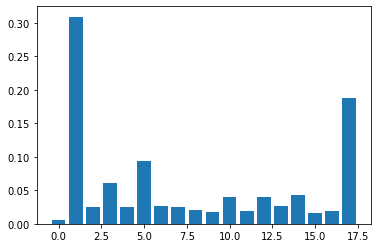

In [28]:
from sklearn.datasets import make_regression
from matplotlib import pyplot

importance = rf_best.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [29]:
pesos = pd.DataFrame(importance)
pesos.head()

,0
0,0.004994
1,0.308941
2,0.025557
3,0.060784
4,0.025526


In [30]:
pesos = pesos.rename(columns={0: 'pesos'}, index={0:'CriterioConfirmacao', 1:'FaixaEtária', 2:'Sexo', 3:'RacaCor', 4:'Febre', 5:'DificuldadeRespiratoria', 6:'Tosse', 7:'Coriza', 8:'DorGarganta', 9:'Diarreia', 10:'Cefaleia', 11:'ComorbidadePulmao', 12:'ComorbidadeCardio', 13:'ComorbidadeRenal', 14:'ComorbidadeDiabetes', 15:'ComorbidadeTabagismo', 16:'ComorbidadeObesidade', 17:'FicouInternado'})
pesos = pesos.reset_index()
pesos = pesos.rename(columns={'index': 'var'})
pesos

,var,pesos
0,CriterioConfirmacao,0.004994
1,FaixaEtária,0.308941
2,Sexo,0.025557
3,RacaCor,0.060784
4,Febre,0.025526
5,DificuldadeRespiratoria,0.094307
6,Tosse,0.026797
7,Coriza,0.024356
8,DorGarganta,0.020099
9,Diarreia,0.017433


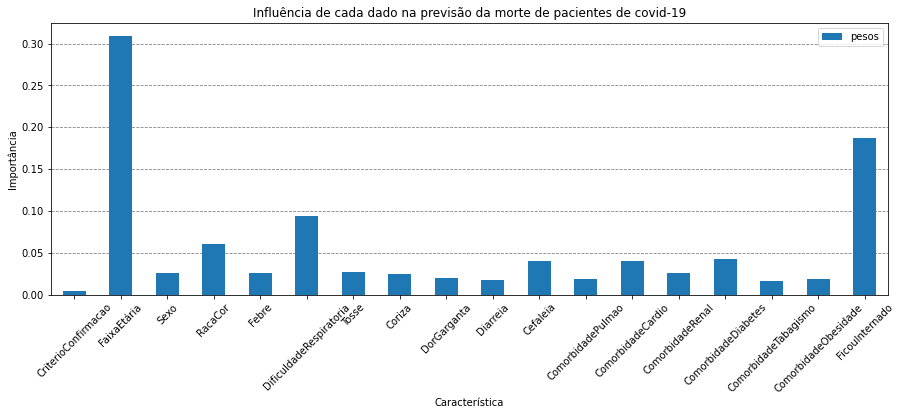

In [31]:
plt.figure(figsize=(15,5))  
ax = plt.gca()                                              
plt.title('Influência de cada dado na previsão da morte de pacientes de covid-19')            

pesos.plot(kind='bar', x= 'var', ax=ax) 

plt.ylabel('Importância')                                              
plt.xlabel('Característica')                                            
plt.xticks(rotation=45)                                          
ax.set_axisbelow(True)  
ax.yaxis.grid(color='gray', linestyle='dashed') 

#### Podemos observar que a faixa etária e o fato de o paciente estar internado ou não, são grandes influentes na decisão tomada pelo modelo, seguidos da dificuldade respiratória e a da raça (que talvez possa ser associada com a condição socioeconômica em um projeto futuro)

# **Salvando o modelo**

In [68]:
from sklearn.externals import joblib

In [69]:
joblib.dump(rf_best, 'model.pkl')

['model.pkl']

In [70]:
model = joblib.load('model.pkl')

In [71]:
teste = np.array([[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])
model.predict(teste)

array([0], dtype=int64)

In [522]:
model.predict_proba(teste)

array([[0.9972137, 0.0027863]])

#### Para ver código do deploy do aplicativo em flask, volte à pasta do projeto e procure o arquivo .py e o template, leia os dois em conjunto. (imagem abaixo)

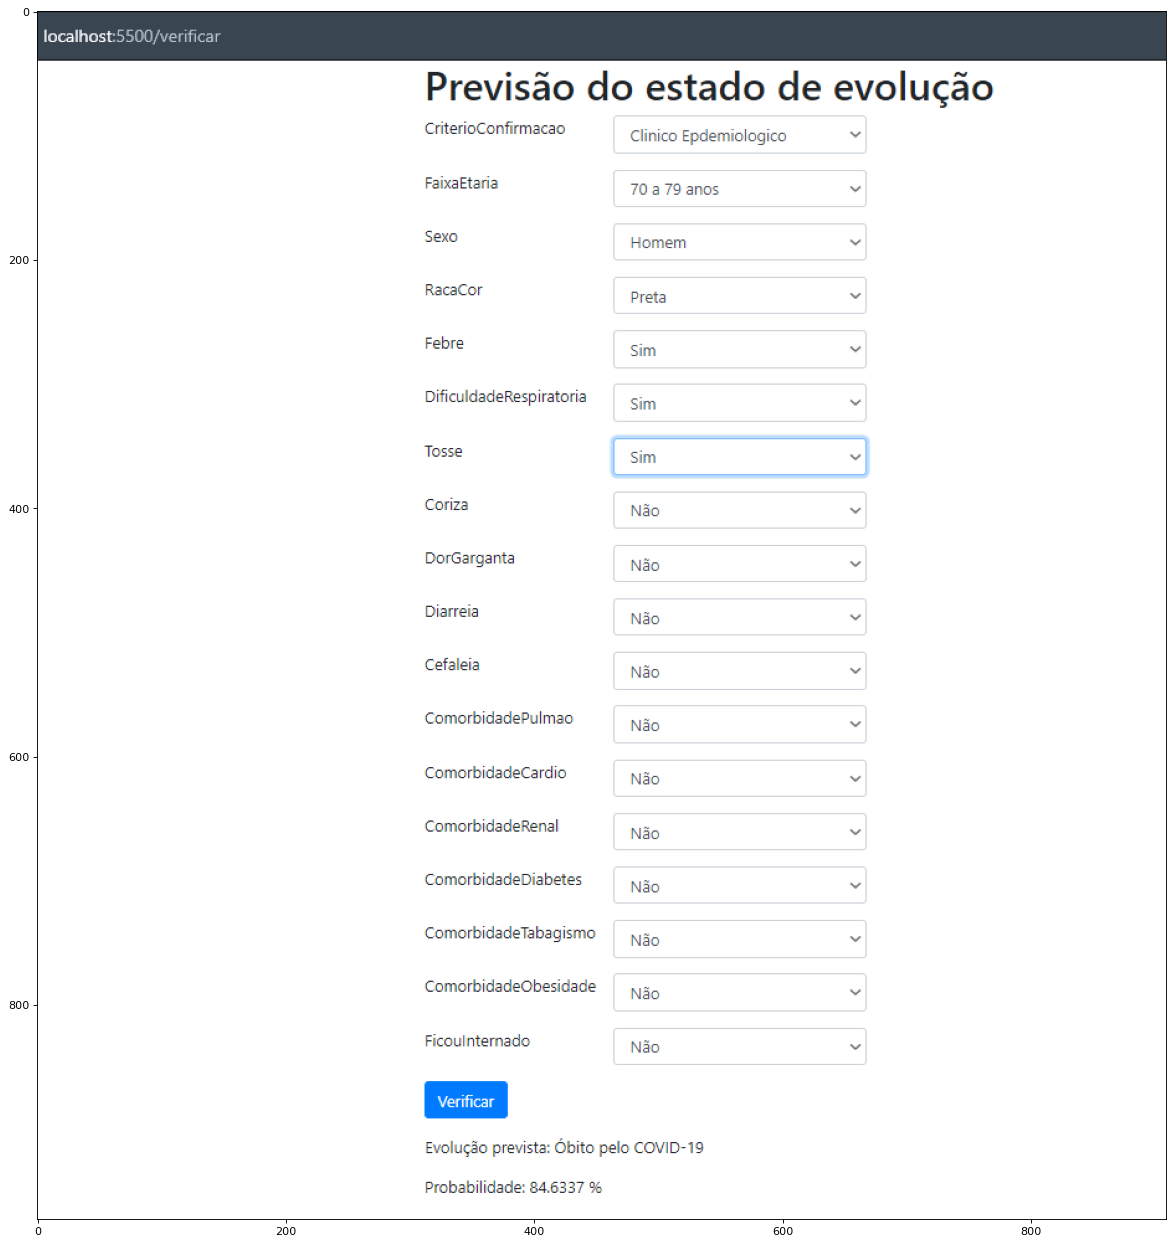

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
image = mpimg.imread("app.png")
plt.imshow(image)
plt.show()